# 04 - Applied ML

***

# TO DO: complete exercise 2.2, tune parameters, comment


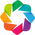

In [6]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
hv.extension('bokeh','matplotlib')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import networkx as nx
%matplotlib inline 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

***
## Assignment


### Question 1: Propensity score matching 

*In this exercise, you will apply propensity score matching, which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.*

*We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.*

_**Dataset description**_

* _treat: 1 if the subject participated in the job training program, 0 otherwise_
* _age: the subject's age_
* _educ: years of education_
* _race: categorical variable with three possible values: Black, Hispanic, or White_
* _married: 1 if the subject was married at the time of the training program, 0 otherwise_
* _nodegree: 1 if the subject has earned no school degree, 0 otherwise_
* _re74: real earnings in 1974 (pre-treatment)_
* _re75: real earnings in 1975 (pre-treatment)_
* _re78: real earnings in 1978 (outcome)_

*If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the "Design of Observational Studies". Even just reading the first chapter (18 pages) will help you a lot.*


In the first place, we read the data into a pandas dataframe called _df_, using the ID column as the index.

In [2]:
df=pd.read_csv('./lalonde.csv',index_col='id')

#### 1. A naive analysis
*Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").*

*What might a naive "researcher" conclude from this superficial analysis?*

We use the method _describe()_ to obtain a numerical description of the columns re78 of each of the groups, first for the control group and afterwards for the treated group. In addition, we compare the percentual difference in mean, median and standard deviation from both groups. For this purpose, we create a function *calculate_differences*, which given a column name, a function to aggregate results (in our case, mean, median and std) and the name of said function computes the percentual difference as the difference between the aggregated values of each of the columns divided by their mean value. We do not compute the percentual change as the statistics are obtained in different groups instead of the same in different times.


In [3]:
#Numerical description of control group
print('\033[1m' + 'CONTROL GROUP' +'\033[0m')
df[df.treat==0]['re78'].describe()

CONTROL GROUP


count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [4]:
#Numerical description of treated group
print('\033[1m' + 'TREATED GROUP' +'\033[0m')
df[df.treat==1]['re78'].describe()

TREATED GROUP


count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [5]:
def calculate_diff(data,column,function,string):
    '''Compute the percentual differences pf a column between treated and control group
    INPUT:
        data: dataframe with the data
        column: which column to compute the differences on
        function: function to aggregate results before comparing the difference
        string: name of the operation used to aggregate
    OUTPUT:
        percentual difference
    
    '''
    #Compute percentual difference between the given column for treated and not treated as the difference divided by the mean
    # of the values
    diff_salary=(function(data[data.treat==0][column])-function(data[data.treat==1][column]))*100/ \
            ((function(data[data.treat==0]['re78'])+function(data[data.treat==1]['re78']))/2)
    
    print('{} difference is {} %'.format(string,diff_salary))
    return diff_salary

print('Percentage differences from the treated to control groups')
#Mean percentage difference
mean_78=calculate_diff(df, 're78',np.mean,'mean')

#Median percentage difference
median_78=calculate_diff(df, 're78',np.median,'median')

#std percentage difference
std_78=calculate_diff(df, 're78',np.std,'std')

Percentage differences from the treated to control groups
mean difference is 9.52540751207665 %
median difference is 16.142723995076352 %
std difference is -7.407657416688338 %


According to statistics obtained from the above summary, re78's mean from treated and control groups is almost the same, with the control group being only 5% higher. The median is also a 10% higher in the control group, while the standard deviation is an 8% smaller. This indicates that the results are more stable in that group.

Finally, we also plot the distribution of the income in 1978, and show the density plot for each of the groups, with the control group in blue and the treated one in red.

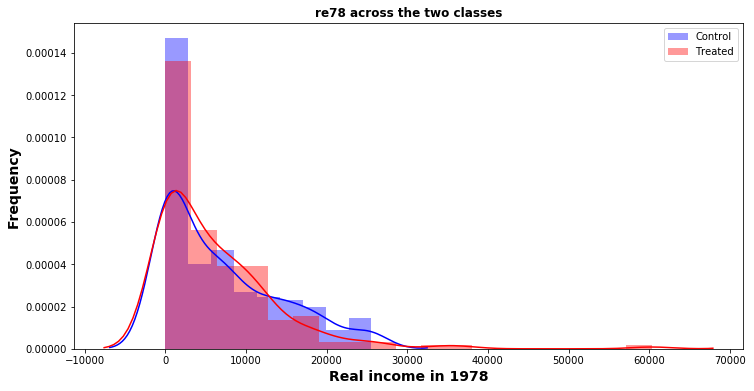

In [6]:
#Resize figure
plt.figure(figsize=(12,6))

#Histogram and density plot of re78 scores of control
ax_control = sns.distplot(df[df.treat==0]['re78'], color="b", kde=True, label='Control')
#Histogram and density plot of re78 scores of treated
ax_treat = sns.distplot(df[df.treat==1]['re78'], color="r", kde=True, label='Treated')

#Axis labels
ax_treat.set_xlabel('Real income in 1978', fontsize=14).set_weight('bold')
ax_treat.set_ylabel('Frequency', fontsize=14).set_weight('bold')
ax_treat.set_title('re78 across the two classes').set_weight('bold')

#Legend
plt.legend()

In the plot can be observed that the distribution in both plots are pretty similar. Nevertheless, this plot also shows that, while, the incomes are in the lower bins are similar, there are more subjects from the treated group in the lower bins, and more people from the control group in the higher ones.

Taking into account the statistics and the plot, with naive analysis one might conclude that the treatment didn't have any affect at all, or if it did, it was slightly negative.

*** 
#### 2. A closer look at the data

*You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.*

*For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.*

*What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.*

As before, as a first step of the numerical comparison we use the function *describe()* and compare all the available columns of the dataframe.

In [7]:
#Numerical description of control group
print('\033[1m' + 'CONTROL GROUP' +'\033[0m')
df[df.treat==0].describe()

CONTROL GROUP


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


In [8]:
#Numerical description of treated group
print('\033[1m' + 'TREATED GROUP' +'\033[0m')
df[df.treat==1].describe()

TREATED GROUP


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


First, we can observe that the number of people treated, 185, is much smaller than the number of people not-treated, 429. Additionally, it should also be mentioned that there is difference in the population distribution from both classes, with only 19% of married people in the treated group against the 51% in the control group, and also with differences in the degree field, hispan people and, specially, the percentage of black. 

Second, we can observe that the difference in the incomes could also be found in re74 and re75, being much higher in the control group. Thus, to continue the numerical comparison, we also study the distribution on re74 and re75, to observe how the data has changed over time and how big were the differences pre-treatment.

In [9]:
#Mean percentage difference
mean_74=calculate_diff(df,'re74',np.mean,'mean')
#Median percentage difference
median_74=calculate_diff(df,'re74',np.median,'median')
#std percentage difference
std_74=calculate_diff(df,'re74',np.std,'std')

mean difference is 52.85502178944913 %
median difference is 55.3235979788471 %
std difference is 25.21105010649681 %


In [10]:
#Mean percentage difference
mean_75=calculate_diff(df,'re75',np.mean,'mean')
#Median percentage difference
median_75=calculate_diff(df,'re75',np.median,'median')
#std percentage difference
std_75=calculate_diff(df,'re75',np.std,'std')

mean difference is 14.016458028651584 %
median difference is 23.604429889656764 %
std difference is 1.0259042988723364 %


The above results show that pre-treatment the difference between the two groups were quite great with 52% difference in 1974. However, they descended to just 14.02% on 1975, that is, there was a 38% percent change from one yewat to the next one, still without having had a treatment. From 1975 to 1978, after the treatment this descent was 6%. Given the change in 1975 to 1976 without treatment, it seems that the change may just be do to the continuating descent and have nothing to do with the treatment, but that the treatment did not affect them negatively as it may seem before, as the starting point was not similar at the beginning.

Then, we continue comparing the difference in the classes with plot. First, we plot the differences found in the numerical comparison with a stacked plot, showing the percentage difference of the mean and median in each of the years.

The results show what was already observed before, there is a great descent of the percentage difference from 1974 (re74) to 1975 (re75), pre-treatment, while this difference can still be found but is smaller after the treatment.

In [11]:
%%opts Bars [height= 250 width=330 toolbar='above' ] 

#Mean percentage difference
data_mean=[('re74',mean_74),('re75',mean_75),('re78',mean_78)]
#Median percentage difference
data_median=[('re74',median_74),('re75',median_75),('re78',median_78)]

#Stacked plot
hv.Bars(data_median,kdims=[hv.Dimension('label')],vdims=[hv.Dimension('% difference',range=(0,110))],label='median perc diff.')*\
            hv.Bars(data_mean,label='mean perc. diff.')


:Overlay
   .Bars.Median_perc_diff_full_stop         :Bars   [label]   (% difference)
   .Bars.Mean_perc_full_stop_diff_full_stop :Bars   [x]   (y)

Then, we compare the distribution of the data from each of the feature columns in each of the classes. We create a function *return_hist*, which computes the histogram for the data column of the class (treated or control) passed as parameters.

In [12]:

%opts Histogram [tools=['hover'] height= 250 width=330 toolbar='above' shared_datasource=False shared_axes=False] (alpha=0.5)
def return_hist(data, col,class_):
    '''Create and histogram of the column col and for the population with treat=class_
    INPUT
        data: dataframe
        col: column to plot the data from
        class_: of the treat column (either 0 or 1)
    OUTPUT
        histogram
        '''
    #Compute the frequency and edges from an histogram with 15 bins
    freq,edge=np.histogram(data.loc[df['treat']==class_][col],15,density =True)
    
    #Holoview histogram with the data returned by numpy
    return hv.Histogram((freq,edge),kdims=[hv.Dimension(col,range=(min(edge)-max(edge)*0.1-0.5,max(edge)*1.2+0.5))], \
                                                 label='Treated = '+ str(class_)).redim.range(Frequency=\
                                                  ((min(freq)-max(freq)/10,max(freq)+max(freq)/10))).opts(style=dict(alpha=0.4))



Using *return_hist* we create a histogram per feature of the dataframe overlapping the data for the treated and not treated to compare them better. In order to do so, we obtain a list of all the features, removing 'treat' as it is the class feature and showing them in a 3 by 3 plot. 

We can see from the density histogram plot of re74 that both groups tend to have a majority of population concentrated in the lowest income bin. In the treated group, this continues on the re75 histogram whereas the control group has a more spread out distribution in the population groups. This change in the distribution is also prominent in re78, when the number of people in the lowest bin for the treated class divides by 2 and the income generally grows, but does show quite less than in the control group.

In the rest of the features the differences are smaller. The biggest one, as was already observed is in the number of black people. Differences can also be observed in the number of married people and in the distribution of the number of years of education, which tends to be bigger for the treated group.

In [13]:

%%output backend='bokeh'
%%opts Layout [shared_axes=False shared_datasource=False]
plots=[]

#List of columns without treat
cols=list(df.columns)
cols.remove('treat')

#One histogram per feature
for col in cols:
    plots.append(return_hist(df.copy(), col,0)*return_hist(df.copy(), col,1))

#Show the plots in a 3x3 layout
hv.Layout(plots).cols(3).opts(plot=dict(shared_datasource=False,shared_axes=False))

:Layout
   .Overlay.I    :Overlay
      .Histogram.Treated_equals_0 :Histogram   [age]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [age]   (Frequency)
   .Overlay.II   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [educ]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [educ]   (Frequency)
   .Overlay.III  :Overlay
      .Histogram.Treated_equals_0 :Histogram   [black]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [black]   (Frequency)
   .Overlay.IV   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [hispan]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [hispan]   (Frequency)
   .Overlay.V    :Overlay
      .Histogram.Treated_equals_0 :Histogram   [married]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [married]   (Frequency)
   .Overlay.VI   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [nodegree]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [nodegree]   (Frequency)
   .Overlay.VII  :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re74]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re74]   (Frequency)
   .Overlay.VIII :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re75]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re75]   (Frequency)
   .Overlay.IX   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re78]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re78]   (Frequency)

For the non-categorical features, that is, with more than two values (re74, re75, re78, age, and educ) we use boxplots to study the distributions. We create a function return_boxWhisker that, given a dataframe and a column name, computes the boxplot of that feature separating by classes. We show the the results in a 2 by 3 layout. 


In [14]:

%%output backend='bokeh'
%%opts BoxWhisker [tools=['hover'] height= 250 width=250 toolbar='above' shared_datasource=False shared_axes=False]
%%opts Layout [shared_axes=False shared_datasource=False]


def return_boxWhisker(data, col):
    '''
    Compute the boxplot for the feature col of dataframe data separated by treat class
    INPUT
        data: dataframe to compute the boxwhisker from
        col: name of the column feature of the dataframe
    OUTPUT:
        boxplot
    
    '''
    return hv.BoxWhisker(data.loc[:,['treat',col]],kdims=[hv.Dimension('treat',label='treated')],vdims=[hv.Dimension(col)])

#Names of the columns that are not categorical
cols=['educ', 'age', 're74', 're75', 're78']#list(set(cols).difference(set(['black','hispan','married','nodegree'])))

#List of boxplots
plots_box=[]
for col in cols:
    #Boxplot of current column
    plots_box.append(return_boxWhisker(df, col))

#Layout of the box plots
hv.Layout(plots_box).cols(3).opts(plot=dict(shared_datasource=False,shared_axes=False))             

:Layout
   .BoxWhisker.I   :BoxWhisker   [treat]   (educ)
   .BoxWhisker.II  :BoxWhisker   [treat]   (age)
   .BoxWhisker.III :BoxWhisker   [treat]   (re74)
   .BoxWhisker.IV  :BoxWhisker   [treat]   (re75)
   .BoxWhisker.V   :BoxWhisker   [treat]   (re78)

It can be observed that the number of years of education is very similar in both classes, but has more outliers in the control group. Although the median is similar, it can be observed that the age of the population in the treated group tends to be more condensed between 20 and 30 years.

Regarding the income, in 1974 (re74) there was a great difference between the groups, with a much higher income in general among the control group. Nevertheless,  this difference gets smaller in 1975 (re75), not because the income is greater in the treated group, but rather because it is smaller in the control group. Finally in 1978 (re78), after the treatment, the two classes seem to have very similar distributions.

Given this analysis, it seems that the two cannot be directly compared, given the difference in the populations and the income pre-treatment.

***
#### 3. A propensity score model

*Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores:*


>from sklearn import linear_model 

>logistic = linear_model.LogisticRegression()

*Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.). To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or this article.*

*Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups. (See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores. If you want even more information, read this article.)*

In the first place, we divide our data in the features (train_x), that is, the data pre-treatment, without re78 and in the output (train_y) we are trying to predict, which is the treat column. We initialise a logistic regression model, using the _lbfgs_ solver and the option _multinomial_ to minimize the loss across the entire population. In addition, before fitting the model we standarize the data using _StandardScaler_ fitted to our data, to ensure all the data is in the same scale so we can compare the resulting weights afterwards. Finally, we fit the model to our data and compute the propensity score as the probability of being treated.


In [15]:
#Separate data in features and output
train_x=df.drop(['treat','re78'],axis=1)
train_y=df['treat']

#Initialize logistic regression 
log_model=LogisticRegression(solver='lbfgs',multi_class = 'multinomial')
#Initialize standarization scaler fitted to our data
scaler=StandardScaler().fit(train_x)

#Standardize data
train_x_scaled=scaler.transform(train_x)

#Fit logistic regression
log_model.fit(train_x_scaled,train_y)

#Probability of receiving treatment
res=log_model.predict_proba(train_x_scaled)

The first thing we study is the meights of the resulting model to understand what features affect more to the result. We observe that the more determinant feature to being treated is being black, followed negatively by the income in 1974, that is, the less income in that year, the higher the proababily of being treated. The age and the income in 1975 barely have any effect in the result.

In [16]:
print('\033[1m' +'Weights of the resulting model:' + '\033[0m')
#Model weights
for c, coef in zip(train_x.columns,log_model.coef_.T):
    print(c, coef)

Weights of the resulting model:
age [ 0.0751421]
educ [ 0.20586182]
black [ 0.74149196]
hispan [ 0.15298252]
married [-0.20332909]
nodegree [ 0.16674543]
re74 [-0.2279987]
re75 [ 0.08500699]


We analyse the results obtained, first studying the data without considering the real labels of being treated and studying only the propensity score. 

In this first plot, we show the probabilities or receiving  or not treatment in each of the people in the population. We create a function *return_bar* that given the index of a subject, returns in a bar plot its probability of being treated or not. It can be observed that in a lot of indexed the probability is not balanced, an is very skewed towards either being treated or not. Despite this, several cases where the probabilities are more balanced around 50%-50% or 40%-60% can be found.

In [17]:
%%output backend='bokeh'
def return_bar(index):
    '''
    Bar chart of given index with the probability of being treated or not for the given index
    INPUT:
        index: of the current subject
    OUTPUT:
        bar plot
    '''
    #Obtain plot
    plot=(hv.Bars(res[index],kdims=['treated'],vdims=['Probability'],group='Probability of').redim(
        Probability=dict(range=(0,1))))
    return plot

#Dynamic bar to change over the indexes
dmap = hv.DynamicMap(return_bar, kdims=[hv.Dimension('index',range=(0,len(res)-1))])
dmap

:DynamicMap   [index]

To continue this study, we observe how the propensity score or probability of being treated is distributed across the entire population with an histogram. We first, obtain the bins and frequency in each bin and afterwards plot the histogram.

We can observe that, in general, the majority of data points have the probability smaller 0.5 or bigger than 0.5, with very few points around this value. This leads us to conclude that the selection process is not really random, and that there is a big skew depending on the features.

In [18]:
#Frequency and edges of the probability of being treated 
freq,edges=np.histogram(res[:,1],bins=10)
#Histogram limiting to 150 (a little over the maximum) the y axis
hv.Histogram((freq,edges),kdims=[hv.Dimension(
    'x',label='Probability Distribution of being treated')]).redim.range(Frequency=(0,150))

:Histogram   [x]   (Frequency)

Lastly, we compare the results taking into account whether the specific subject received or not treatment. For this pupose we plot the histogram and density plot of the propensity scores overlapping. 

With this plot, the skew of the classes is clear. The people who were finally treated had a set of characteristics that made them quite more likely to be treated with a propensity score around 0.6. On the other hand, in the control group this probability is quite small with the mode around 0.2. Thus, it is clear that the naive direct comparison we first did cannot be made, and that a matching is needded.

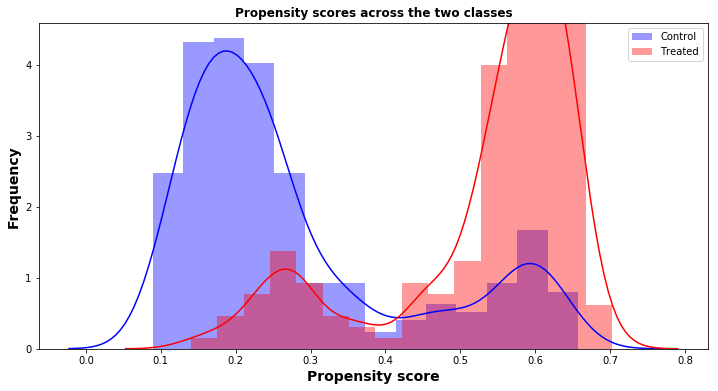

In [19]:
#Resize figure
plt.figure(figsize=(12,6))

#Histogram and density plot of propensity scores of control
ax_control = sns.distplot(res[df.treat==0][:,1], color="b", kde=True, label='Control')
#Histogram and density plot of propensity scores of treated
ax_treat = sns.distplot(res[df.treat==1][:,1], color="r", kde=True, label='Treated')

#Axis labels
ax_treat.set_xlabel('Propensity score', fontsize=14).set_weight('bold')
ax_treat.set_ylabel('Frequency', fontsize=14).set_weight('bold')
ax_treat.set_title('Propensity scores across the two classes').set_weight('bold')

#Legend
plt.legend()

***
#### 4. Balancing the dataset via matching

*Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)*

*Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.*

*After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).*

*Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?*

We use networkx to match the propensity scores, creating a bipartite graph which connects all subjects from the control group to all subjects from the treated group. This allows us to find the closest match as the minimum distance between nodes. 

With this purpose in mind, we first create two dataframes, one with the propensity scores for the control class and another one for the treated class. Then, we iterate through each row, that is, each subject in each of this dataframes to compare all possible combinations. We calculate the distance between the propensity scores as simply the absolute difference between the two values. As this is minimization problem, i.e. the smaller the distance the closer the match, and we use a maximization function for the matching, we have to invert the problem. Considering that propensity scores are probabilities, and thus are bounded between 0 and 1, we simply do 1-absolut\_value to invert it. Then, we add and edge to our graphconnecting the index in the treated group and the index in the control group, setting that distance as the weight.

Finally, we compute the matching between the edges using the function *max_weight_matching* from networkx. This function computes a subset of edges, where no node is repeated. We use the *maxcardinality* option to ensure we compute the matching with maximum final weight (we have maximized the weights in all the graph).

In [20]:

#Create a dataframe with propensity scores for treated and control classes
prop_treat=pd.DataFrame(index=df[df.treat==1].index, data=res[df.treat==1][:,1]) #treat
prop_control=pd.DataFrame(index=df[df.treat==0].index, data=res[df.treat==0][:,1]) #control

#Create graph
graph=nx.Graph()
#Iter through every possible combination of treat and control indexes and add and edge with their distance
for idx_treat, treat in prop_treat.iterrows():
    for idx_control, control in prop_control.iterrows():
        #distance is the absolute difference between the probability of being in the treated or control group.
        #We do 1-distance to convert from minimization to maximization problem
        w=1-np.abs(treat.values - control.values)
        #add the edge with the weight to the graph
        graph.add_edge(idx_treat, idx_control, weight=w)
        
#Match the edges with maximal weight
matching = nx.max_weight_matching(graph, maxcardinality=True)
#Save in a new dataframe all the subjects who have been matched
df_match = df.loc[df.index.isin(matching.keys())]

#Show equal number of subjects in each
print('Number of subjects in treat group: {}'. format(sum(df_match.treat==1)))
print('Number of subjects in control group: {}'. format(sum(df_match.treat==0)))

Number of subjects in treat group: 185
Number of subjects in control group: 185


After the matching, we analysis the results. First we use the function *return_hist* to repeat the analysis following the same steps. We can observe that the classes tend to be much more close than before, with similar distributions of the values in both cases. However, it should be noted that the 'black' feature, were more differences could be found before, still shows a great disparity between the two classes, although it has been reduced.

Of couse, it should be metioned that the balancing is due to changes in the control group, where the subjects that did not match well have been ignored.

In [21]:
%%output backend='bokeh'
%%opts Layout [shared_axes=False shared_datasource=False]

#ANALYSIS HISTOGRAMS
plots=[]

#List of columns without treat
cols=list(df_match.columns)
cols.remove('treat')

#One histogram per feature
for col in cols:
    plots.append(return_hist(df_match.copy(), col,0)*return_hist(df_match.copy(), col,1))

#Show the plots in a 3x3 layout
hv.Layout(plots).cols(3).opts(plot=dict(shared_datasource=False,shared_axes=False))

:Layout
   .Overlay.I    :Overlay
      .Histogram.Treated_equals_0 :Histogram   [age]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [age]   (Frequency)
   .Overlay.II   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [educ]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [educ]   (Frequency)
   .Overlay.III  :Overlay
      .Histogram.Treated_equals_0 :Histogram   [black]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [black]   (Frequency)
   .Overlay.IV   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [hispan]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [hispan]   (Frequency)
   .Overlay.V    :Overlay
      .Histogram.Treated_equals_0 :Histogram   [married]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [married]   (Frequency)
   .Overlay.VI   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [nodegree]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [nodegree]   (Frequency)
   .Overlay.VII  :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re74]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re74]   (Frequency)
   .Overlay.VIII :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re75]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re75]   (Frequency)
   .Overlay.IX   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re78]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re78]   (Frequency)

Next, following the same procedure as before, we use boxplots to analyse the non-categorical data. Here, we can observe better the effect of the matching in this control group. In general, we can see that most of the outliers in the control group features have disappeared. The income in 1974, re74, which was the feature which showed more differences in the analysis in exercise 1.3, still shows a great difference between both groups. The income in 1975 also shows some differences, but much smaller than in the previous year.

In [22]:
#ANALYSIS: BOXPLOTS

#Names of the columns that are not categorical
cols=['educ', 'age', 're74', 're75', 're78']

#List of boxplots
plots_box=[]
for col in cols:
    #Boxplot of current column
    plots_box.append(return_boxWhisker(df_match, col))
    

#Layout of the box plots
hv.Layout(plots_box).cols(3).opts(plot=dict(shared_datasource=False,shared_axes=False))             

:Layout
   .BoxWhisker.I   :BoxWhisker   [treat]   (educ)
   .BoxWhisker.II  :BoxWhisker   [treat]   (age)
   .BoxWhisker.III :BoxWhisker   [treat]   (re74)
   .BoxWhisker.IV  :BoxWhisker   [treat]   (re75)
   .BoxWhisker.V   :BoxWhisker   [treat]   (re78)



***
#### 5. Balancing the groups further

*Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?*

*Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.*



Taking into account the results from the analysis in part 1.4, we still consider that our dataset is not balanced. Two features concretely seem to have differences too big among the groups, being or not black and the incomes in 1974 (we do not consider the incomes in 1975 due to the smaller differences). 

To balance the number of black people, as it is a categorical feature (either 0 or 1) we can just force the match to be between people who have the same value. On the other hand, as re74 is continous we can force matched values to have a similar range. To enforce this, we only add an edge to the graph if the diference between re75 in the control and treated subjects is smaller than some threshold. After some experiments, we set this threshold to 0.5 of the standard deviation of re74 in the treated group.

To be able to do these filterings, we add a column with the propensity scores to the original dataframe and name the resulting dataframe *df_prop*

In [23]:

#Add column with propensity scores to original dataframe
df_prop=df.copy()
df_prop.loc[:,'prop']=res[:,1]
df_prop.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.568661
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.349160
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.591144
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.648603
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.604297


Afterwards, we follow the same steps as before to create the graphs and match subjects. We first create two separate dataframes for control and treat group and define the threshold as 0.5 of standard deviation of re74 in the treat group. Then, as before, we loop through every possible combination adding an edge with the weights if the two subjects under consideration are of the same race and have the incomes in 1974 in a similar range. We finally match again based on maximum weight and study with boxplots the resulting distributions. We save in a dataframe named *df_match_final* the features of the subjects from control and treated group that could be matched.

In [44]:
#Create a dataframe with propensity scores for treated and control classes
prop_treat=df_prop[df_prop.treat==1] 
prop_control=df_prop[df_prop.treat==0]

#Threshold: 0.5*std of re74 in treat group
threshold=np.std(prop_treat['re74'])*0.5

#Create graph
graph=nx.Graph()
#Iter through every possible combination of treat and control indexes and add and edge with their distance
for idx_treat, treat in prop_treat.iterrows():
    for idx_control, control in prop_control.iterrows():
        #If both subjects are not of the same race don't create and edge
        if treat.black!=control.black:
            continue
        #If difference is bigger than threshold don't create an edge
        if (treat['re74']-control['re74'])>threshold:
            continue
            
        #distance is the absolute difference between the probability of being in the treated or control group.
        #We do 1-distance to convert from minimization to maximization problem
        w=1-np.abs(treat['prop'] - control['prop'])
        #add the edge with the weight to the graph
        graph.add_edge(idx_treat, idx_control, weight=w)
        
        
#Match the edges with maximal weight
matching = nx.max_weight_matching(graph, maxcardinality=True)
#Save in a new dataframe all the subjects who have been matched
df_match_final = df.loc[df.index.isin(matching.keys())]

#Show equal number of subjects in each
print('Number of subjects in treat group: {}'. format(sum(df_match_final.treat==1)))
print('Number of subjects in control group: {}'. format(sum(df_match_final.treat==0)))

Number of subjects in treat group: 116
Number of subjects in control group: 116


In [45]:

#Names of the columns that are not categorical
cols=['educ', 'age', 're74', 're75', 're78']

#List of boxplots
plots_box=[]
for col in cols:
    #Boxplot of current column
    plots_box.append(return_boxWhisker(df_match_final, col))
    

#Layout of the box plots
hv.Layout(plots_box).cols(3).opts(plot=dict(shared_datasource=False,shared_axes=False))             

:Layout
   .BoxWhisker.I   :BoxWhisker   [treat]   (educ)
   .BoxWhisker.II  :BoxWhisker   [treat]   (age)
   .BoxWhisker.III :BoxWhisker   [treat]   (re74)
   .BoxWhisker.IV  :BoxWhisker   [treat]   (re75)
   .BoxWhisker.V   :BoxWhisker   [treat]   (re78)

The results show that due to the filtering on the race, only 116 subjects could be matched finally. In addition, the boxplots show that these matchings still have a big divergence on the incomes feature, probably due to the limit in the possible matchings. For this reason, we repeat the analysis without forcing the perfect match, even if it's the most divergent feature.

In [48]:
#Create graph
graph=nx.Graph()
#Iter through every possible combination of treat and control indexes and add and edge with their distance
for idx_treat, treat in prop_treat.iterrows():
    for idx_control, control in prop_control.iterrows():

        if (treat['re74']-control['re74'])>threshold:
            continue
        #distance is the absolute difference between the probability of being in the treated or control group.
        #We do 1-distance to convert from minimization to maximization problem
        w=1-np.abs(treat['prop'] - control['prop'])
        #add the edge with the weight to the graph
        graph.add_edge(idx_treat, idx_control, weight=w)
        
        
#Match the edges with maximal weight
matching = nx.max_weight_matching(graph, maxcardinality=True)
#Save in a new dataframe all the subjects who have been matched
df_match_final = df.loc[df.index.isin(matching.keys())]

#Show equal number of subjects in each
print('Number of subjects in treat group: {}'. format(sum(df_match_final.treat==1)))
print('Number of subjects in control group: {}'. format(sum(df_match_final.treat==0)))

Number of subjects in treat group: 184
Number of subjects in control group: 184


We can observe that with only the filtering on the incomes we still get 184 matches. The plot of the distribution shows, that although the differences in the black feature were not solved, the differences in the income in 1974 and also in the married feature were reduced greatly. Even more, in the boxplots can be seen that the difference in the number of education years and in the income in 1975 is very small

In [51]:
%%output backend='bokeh'
%%opts Layout [shared_axes=False shared_datasource=False]

#ANALYSIS HISTOGRAMS
plots=[]

#List of columns without treat
cols=list(df_match_final.columns)
cols.remove('treat')

#One histogram per feature
for col in cols:
    plots.append(return_hist(df_match_final.copy(), col,0)*return_hist(df_match_final.copy(), col,1))

#Show the plots in a 3x3 layout
hv.Layout(plots).cols(3).opts(plot=dict(shared_datasource=False,shared_axes=False))

:Layout
   .Overlay.I    :Overlay
      .Histogram.Treated_equals_0 :Histogram   [age]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [age]   (Frequency)
   .Overlay.II   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [educ]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [educ]   (Frequency)
   .Overlay.III  :Overlay
      .Histogram.Treated_equals_0 :Histogram   [black]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [black]   (Frequency)
   .Overlay.IV   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [hispan]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [hispan]   (Frequency)
   .Overlay.V    :Overlay
      .Histogram.Treated_equals_0 :Histogram   [married]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [married]   (Frequency)
   .Overlay.VI   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [nodegree]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [nodegree]   (Frequency)
   .Overlay.VII  :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re74]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re74]   (Frequency)
   .Overlay.VIII :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re75]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re75]   (Frequency)
   .Overlay.IX   :Overlay
      .Histogram.Treated_equals_0 :Histogram   [re78]   (Frequency)
      .Histogram.Treated_equals_1 :Histogram   [re78]   (Frequency)

In [50]:

#Names of the columns that are not categorical
cols=['educ', 'age', 're74', 're75', 're78']

#List of boxplots
plots_box=[]
for col in cols:
    #Boxplot of current column
    plots_box.append(return_boxWhisker(df_match_final, col))
    

#Layout of the box plots
hv.Layout(plots_box).cols(3).opts(plot=dict(shared_datasource=False,shared_axes=False))             

:Layout
   .BoxWhisker.I   :BoxWhisker   [treat]   (educ)
   .BoxWhisker.II  :BoxWhisker   [treat]   (age)
   .BoxWhisker.III :BoxWhisker   [treat]   (re74)
   .BoxWhisker.IV  :BoxWhisker   [treat]   (re75)
   .BoxWhisker.V   :BoxWhisker   [treat]   (re78)

****
#### 6. A less naive analysis

*Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program?*

We perform the same analysis as in 1.6, first numerical, obtaining the statistics from each group and their differeneces and afterwards showing the distribution in a plot in addition to a boxplot of the income.

In [28]:
#Numerical description of control group
print('\033[1m' + 'CONTROL GROUP' +'\033[0m')
df_match_final[df_match_final.treat==0]['re78'].describe()

CONTROL GROUP


count      184.000000
mean      5704.273550
std       6290.814136
min          0.000000
25%         49.503838
50%       3545.066000
75%       8340.658000
max      25564.670000
Name: re78, dtype: float64

In [29]:
#Numerical description of treated group
print('\033[1m' + 'TREATED GROUP' +'\033[0m')
df_match_final[df_match_final.treat==1]['re78'].describe()

TREATED GROUP


count      184.000000
mean      6184.481539
std       7562.461678
min          0.000000
25%        436.369825
50%       4207.125500
75%       9609.655500
max      60307.930000
Name: re78, dtype: float64

In [30]:
print('Percentage differences from the treated to control groups')
#Mean percentage difference
mean_78=calculate_diff(df_match_final,'re78',np.mean,'mean')

#Median percentage difference
median_78=calculate_diff(df_match_final, 're78',np.median,'median')

#std percentage difference
std_78=calculate_diff(df_match_final, 're78',np.std,'std')

Percentage differences from the treated to control groups
mean difference is -8.07835613949579 %
median difference is -17.080576505366263 %
std difference is -18.35879916067007 %


We can observe that after the matching the mean income is 8% better treated group than in the control group. The median income is 17% better and there is less difference between the incomes. It should also be noted that the maximum income in the treated group is  more than twice bigger than the maxium in the control group.

In the following figure it is shown the resulting distribution of the income in 1978 after the treatment. The treated group has less subjects in the lower bins, while in the medium income there are more. In the highest bins, the number of subjects are similar.

The boxplot shows that not only on average the control group is shifted towards bigger incomes, but that there are also more outliers with incomes extremely high.

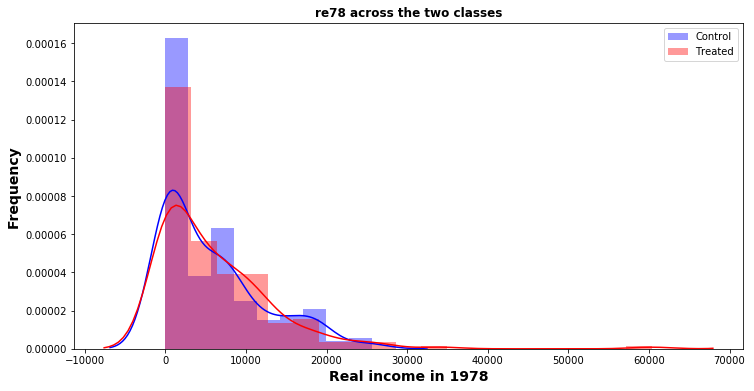

In [31]:
#Resize figure
plt.figure(figsize=(12,6))

#Histogram and density plot of re78 scores of control
ax_control = sns.distplot(df_match_final[df_match_final.treat==0]['re78'], color="b", kde=True, label='Control')
#Histogram and density plot of re78 scores of treated
ax_treat = sns.distplot(df_match_final[df_match_final.treat==1]['re78'], color="r", kde=True, label='Treated')

#Axis labels
ax_treat.set_xlabel('Real income in 1978', fontsize=14).set_weight('bold')
ax_treat.set_ylabel('Frequency', fontsize=14).set_weight('bold')
ax_treat.set_title('re78 across the two classes').set_weight('bold')

#Legend
plt.legend()

In [32]:
#Boxplot
hv.Layout([return_boxWhisker(df_match_final, 're78')]).cols(1).opts(plot=dict(shared_datasource=False,shared_axes=False)) 

:Layout
   .BoxWhisker.I :BoxWhisker   [treat]   (re78)

In conclusion,  the treatment was effective and resulted in bigger incomes, even though with the naive analysis it did not appear so, because of the big differences between the treated and control groups.

- - - - - - -
### Question 2: Applied ML

*We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!*

#### Part 1

*Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link). TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).*

We fetch all the data from the news group dataset and then we compute the TD-IDF features for articles using the TfidfVectorizer function. 
What the fit_transform function gives is a sparse matrix for each of the documents which reflects how important for each document is a word (feature). Note that for example for the first document, just 87 features out of 134410 are relevant. 

In [7]:
#We load all data and all categories from the dataset
newsgroups = fetch_20newsgroups(subset='all')

#Initialize vectorizer
vectorizer = TfidfVectorizer()

#Obtain features
X = vectorizer.fit_transform(newsgroups.data)

#Rename target
y = newsgroups.target
X[0]

<1x173762 sparse matrix of type '<class 'numpy.float64'>'
	with 110 stored elements in Compressed Sparse Row format>

We do not divide straight away the data in train, test, validation, but just in train (90%) and test (10%), in order to later perform cross validation on the train dataset (if we choose 10 fold CV, the validated data will be 9%). For splitting the train and test dataset, we conveniently use the ''' train_test_split''' function, which assigns samples randomly to train or test set. Moreover, the observations and the labels are paired via the index correspondences in X and Y. 


In [8]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#Parameters
train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]
print('Dataset 20newsgroup: train_samples={}, n_features={}, n_classes={}'.format(train_samples, n_features, n_classes))


Dataset 20newsgroup: train_samples=16961, n_features=173762, n_classes=20


----
#### Part 2

*Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature\_importances\_ attribute of your random forest and discuss the obtained results.*

For this part we are using the RandomForestClassifier function, in which we input the number of estimators, the maximum depth and the number of CPUS the task should run on (-1 means all). We afterwards  compute the cross validation score with the given classifier. The performance metric is the accuracy (i.e. the number of items classified correctly / all items). Moreover, wbe chose 5 as the number of folds because it is more efficient (should half the computation time as opposed to using 10), although that would be closer to the assignment required proportions of validation set.
Moreover, we insert a dummy text when we print the accuracy of the various models to be able to see the results by line. (apologies to the reader for the hey spam )

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [70]:
def parameter_tuning(n_estimators, max_depth):
    '''
    Tuning of the parameters of the random forest classifier using grid search. For each possible combination
    of parameters 10-fold cross-validation is used
    
    INPUT:
        n_estimators: List with the values for the number of estimators to try
        max_depth: List with the values for the maximum depth of trees to try
    OUTPUT:
        optimum number of estimators, optimum depth, accuracy for those parameters
        
    '''
    acc= np.zeros((len(n_estimators),len(max_depth))) #Accuracy of the model
    number_of_models = len(n_estimators)*len(max_depth)
    #Grid search: loop through all posible n_estimators values
    model_no = 1                   
    for row, est in enumerate(n_estimators):
        #Loop through the possible depths
        for col, depth in enumerate(max_depth):
            #Initialize the classifier, n_jobs=-1 to use all cores
            rndm_forest=RandomForestClassifier(n_estimators=est, max_depth=depth, n_jobs=-1)
            
            #Accuracy with 5-fold cross validation
            scores = cross_val_score(rndm_forest, X_test, y_test, cv=5, n_jobs=-1)
            
            #Save mean score across folds
            acc[row,col]=np.mean(scores)
            
            # print the result and the progress
            print('accuracy:' , acc[row,col], 'for ', est, 'estimators and trees of depth',depth , ' model ', model_no, 'out of', number_of_models )
            print('hey')
            model_no =model_no+1
    #We get the index of the values that return the maximum accuracy
    idx_est, idx_depth=np.unravel_index(acc.argmax(), acc.shape)

    #Parameters that obtained the maximum accuracy
    n_est_star=n_estimators[idx_est]
    depth_star=max_depth[idx_depth]        
            
    return n_est_star, depth_star, np.max(acc), acc
     

In [71]:
n_estimators= list(range(500,900,60))
depth = list(range(30,90,7))
n_est_star, depth_star, acc_CV, matrix_model = parameter_tuning(n_estimators,depth)  


accuracy: 0.730017241834 for  500 estimators and trees of depth 30  model  1 out of 63
hey
accuracy: 0.732175430332 for  500 estimators and trees of depth 37  model  2 out of 63
hey
accuracy: 0.730438518782 for  500 estimators and trees of depth 44  model  3 out of 63
hey
accuracy: 0.741131152744 for  500 estimators and trees of depth 51  model  4 out of 63
hey
accuracy: 0.742173046054 for  500 estimators and trees of depth 58  model  5 out of 63
hey
accuracy: 0.748482999188 for  500 estimators and trees of depth 65  model  6 out of 63
hey
accuracy: 0.733199752564 for  500 estimators and trees of depth 72  model  7 out of 63
hey
accuracy: 0.744264573039 for  500 estimators and trees of depth 79  model  8 out of 63
hey
accuracy: 0.748062408791 for  500 estimators and trees of depth 86  model  9 out of 63
hey
accuracy: 0.730578830453 for  560 estimators and trees of depth 30  model  10 out of 63
hey
accuracy: 0.736458941589 for  560 estimators and trees of depth 37  model  11 out of 63
h

In [73]:
# the best parameters: 
print(n_est_star, depth_star)

860 65


Not surprisingly, the best parameter in terms of number of trees is the highest from our list, which is 860. That is to be expected since increasing the number of trees only increases the performance. However, the ideal depth is not the highest depth but 65, which is in the middle of the range of values we looked at. 
Given these values, we can now assess different performance measures on the test set. 

In [12]:
#Training 
classifier=RandomForestClassifier(n_estimators=n_est_star, max_depth=depth_star, n_jobs=-1)
classifier.fit(X_train, y_train)

#Test
y_pred=classifier.predict(X_test)

#Metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print('Accuracy: {}, precision: {}, recall: {}'.format(acc, precision, recall))


Accuracy: 0.8461538461538461, precision: 0.8615761500632118, recall: 0.8461538461538461


We can also look at the confusion matrix to find more insights on what gets mostly mistakenly classified. Since the target names are very long, we will only plot the labels as numbers. However we notice that semantically close categories are close to each other (i.e. atl, comp, misc, rec, sci, soc, talk )

In [13]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

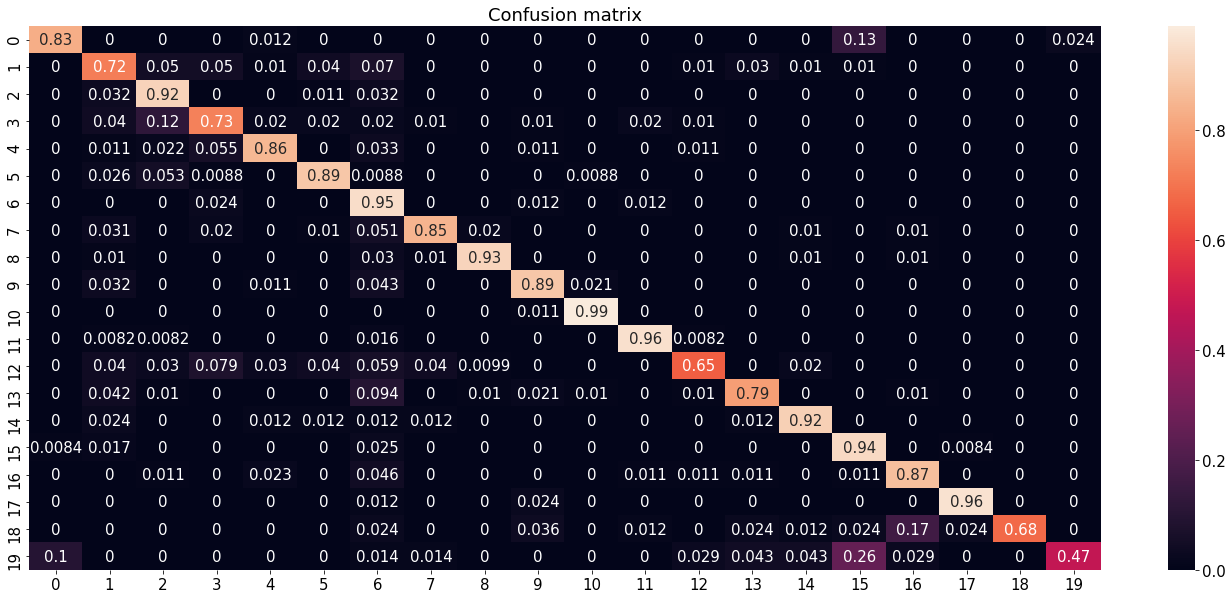

In [27]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(24,10)) #Bigger plot
plt.rcParams.update({'font.size': 15}) #Increment font size
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
sns.heatmap(cnf_matrix, annot=True)

On the x axis lies the predicted labels and on the y axis the true labels. We should look at the high values that are not on the diagonal axis, and for this reason we made a heat map. 
We can see that a lot of news are predicted to be part of category 15 ['soc.religion.christian'] but are in fact in 'talk.religion.misc'. Similarly for second type of misclassification, the two categories are both part of the talk.politics. Both situations show that the errors are coming from semantically close categories, which is a good indicator that the classifier learnt good features.  

In [31]:
[[newsgroups.target_names[19], newsgroups.target_names[15]],
 [newsgroups.target_names[16], newsgroups.target_names[18]]]

[['talk.religion.misc', 'soc.religion.christian'],
 ['talk.politics.guns', 'talk.politics.misc']]

We should now look at the importances of features, given by the classifier. We can notice that they are domain-specific words, not necessarily frequent overall. 

In [33]:
feature_names = np.asarray(vectorizer.get_feature_names())
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(15):
    print("%d. feature %s %d (%f)" % (f + 1, feature_names[indices[f]], indices[f], importances[indices[f]]))


Feature ranking:
1. feature sale 139570 (0.005747)
2. feature windows 165812 (0.005334)
3. feature dod 65684 (0.004971)
4. feature clipper 55485 (0.004488)
5. feature bike 46061 (0.004242)
6. feature car 52100 (0.004142)
7. feature hockey 85770 (0.003738)
8. feature space 145613 (0.003241)
9. feature israel 92333 (0.003089)
10. feature god 80391 (0.003087)
11. feature cars 52328 (0.002894)
12. feature encryption 69924 (0.002890)
13. feature baseball 44285 (0.002799)
14. feature re 133530 (0.002777)
15. feature mac 105625 (0.002718)
